# 4D seismic inversion

In [2]:
from tqdm import tqdm
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Wedge
from pylops.avo.poststack import PoststackLinearModelling
from pylops.basicoperators import *
from pylops.basicoperators import HStack as HStacklop
from pylops.basicoperators import VStack as VStacklop
from pylops.utils.wavelets import ricker
from pyproximal.optimization.segmentation import *
from pyproximal.proximal import *
from scipy import ndimage

plt.style.use('seaborn-v0_8-poster')

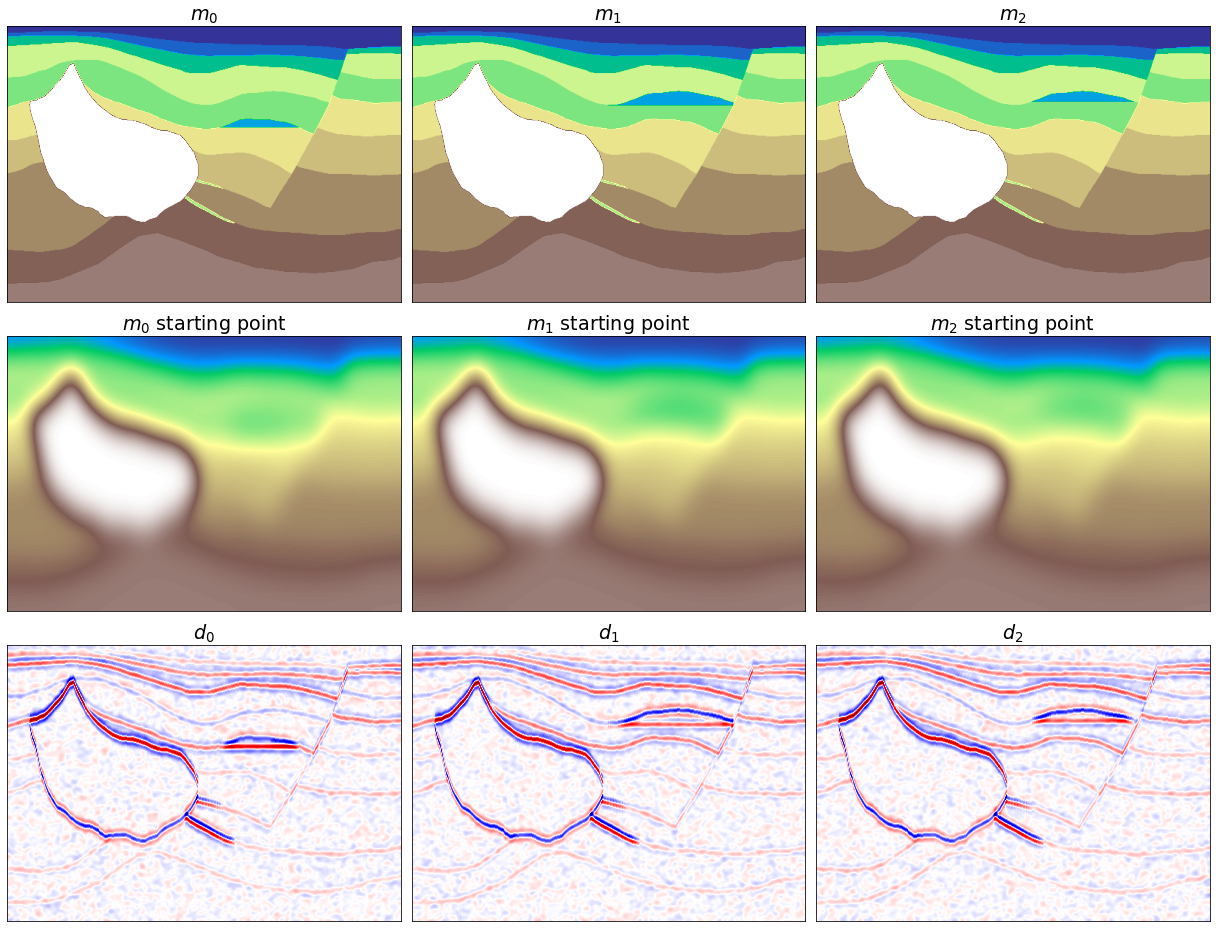

In [16]:
# Data Loading
m0, m1, m2 = [np.load(f'../Data/m{n}.npy') for n in range(3)]
m0, m1, m2 = np.log(m0), np.log(m1), np.log(m2)
d0, d1, d2 = [np.load(f'../Data/d{n}.npy') for n in range(3)]
dn0, dn1, dn2 = [np.load(f'../Data/dn{n}.npy') for n in range(3)]

m0_st, m1_st, m2_st = ndimage.gaussian_filter(m0, 20), ndimage.gaussian_filter(m1, 20), ndimage.gaussian_filter(m2, 20)

fig, axs = plt.subplots(3, 3, figsize=(17, 13))

_vmin, _vmax = m0.min(), m0.max()
_cmap = 'terrain'

axs[0, 0].imshow(m0, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
axs[0, 1].imshow(m1, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
s=axs[0, 2].imshow(m2, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')

axs[1, 0].imshow(m0_st, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
axs[1, 1].imshow(m1_st, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
axs[1, 2].imshow(m2_st, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')

_vmin, _vmax = dn0.min(), dn0.max()
_cmap = 'seismic'
axs[2, 0].imshow(dn0, cmap=_cmap, vmin=-_vmax, vmax=_vmax, aspect='auto')
axs[2, 1].imshow(dn1, cmap=_cmap, vmin=-_vmax, vmax=_vmax, aspect='auto')
axs[2, 2].imshow(dn2, cmap=_cmap, vmin=-_vmax, vmax=_vmax, aspect='auto')

axs[0, 0].set(title='$m_0$');
axs[0, 1].set(title='$m_1$');
axs[0, 2].set(title='$m_2$');

axs[1, 0].set(title='$m_0$ starting point');
axs[1, 1].set(title='$m_1$ starting point');
axs[1, 2].set(title='$m_2$ starting point');

axs[2, 0].set(title='$d_0$');
axs[2, 1].set(title='$d_1$');
axs[2, 2].set(title='$d_2$');

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('models.png', dpi=150)

In [5]:
# Create the forward operator
nt0, nx = m0.shape
dt0 = 0.008
t0 = np.arange(nt0) * dt0
dx = 4
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav // 2 + 1], 8)
_G = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)
G = BlockDiag([_G, _G, _G])

## TVFlow inversion

\begin{multline*}
m^{j+1} = \underset{m}{\mathrm{argmin}} \left\{ \frac{1}{2} ||d- G m||^2_2 + \sum^{nt}_{i=1} TV(m_i) + \mathcal{M}(m, \hat{v}) \right\} \\ =
\underset{m}{\mathrm{argmin}} \left\{
\frac{1}{2} \left\lVert
\begin{bmatrix}
d \\
0
\end{bmatrix} -
\begin{bmatrix}
G \\
\mathcal{M}_m
\end{bmatrix} m \right\rVert + \sum^{nt}_{i=1} TV(m_i)
\right\}
\end{multline*}

\begin{equation*}
	v^{j+1} = \underset{v}{\mathrm{argmin}} \left\{ \frac{1}{2}\lVert d_v-\mathcal{M}_v v\rVert^2_2 + \sum TV(v_{z_i}) + \sum TV(v_{x_i}) \right\}
\end{equation*}

In [17]:
m = np.hstack([m0.ravel(), m1.ravel(), m2.ravel()])
d = np.hstack([d0.ravel(), d1.ravel(), d2.ravel()])
dn = np.hstack([dn0.ravel(), dn1.ravel(), dn2.ravel()])

In [18]:
# To define a starting model we can use the smoothed velocity obtained before
m_start = np.hstack([m0_st.ravel(), m1_st.ravel(), m2_st.ravel()])

In [29]:
trunc_noise = lambda array, lim = 5e-3: np.where((array < lim) & (array > -lim), 0, array)

def plot_m(m, title=''):
    mtvflow0 = m[:nt0 * nx].reshape(d1.shape)
    mtvflow1 = m[nt0 * nx:nt0 * nx * 2].reshape(d1.shape)
    mtvflow2 = m[nt0 * nx * 2:].reshape(d1.shape)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    _vmin, _vmax = mtvflow0.min(), mtvflow0.max()
    _cmap = 'terrain'
    axs[0].imshow(mtvflow0, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
    axs[1].imshow(mtvflow1, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
    axs[2].imshow(mtvflow2, cmap=_cmap, vmin=_vmin, vmax=_vmax, aspect='auto')
    axs[0].set(title='$m_0$')
    axs[1].set(title='$m_1$')
    axs[2].set(title='$m_2$')

    if title == '':
        fig.suptitle(f'Iteration {i}', fontsize=25)
    else:
        fig.suptitle(f'{title}', fontsize=25)

    for ax in axs.flatten():
        ax.set(xticks=[], yticks=[])
    plt.tight_layout()
    #plt.show()

def plot_vel(v, plot_angles, lim=5e-3, clim = 1/10):
    vxflow1 = v[:nt0 * nx].reshape(d1.shape)
    vzflow1 = v[nt0 * nx:nt0 * nx * 2].reshape(d1.shape)
    vxflow2 = v[nt0 * nx* 2:nt0 * nx * 3].reshape(d1.shape)
    vzflow2 = v[nt0 * nx*3:].reshape(d1.shape)

    if plot_angles:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))
        cmap = cc.cm.CET_C3

        angles1 = np.arctan2(trunc_noise(vzflow1, lim=lim), trunc_noise(vxflow1, lim=lim))
        mask1 = ((vzflow1 < lim) & (vzflow1 > -lim)) & ((vxflow1 < lim) & (vxflow1 > -lim))
        angles1 = np.where(angles1 <= lim, angles1 + 2 * np.pi, angles1)
        angles1 = np.where(mask1, np.nan, angles1)

        angles2 = np.arctan2(trunc_noise(vzflow2, lim=lim), trunc_noise(vxflow2, lim=lim))
        mask2 = ((vzflow2 < lim) & (vzflow2 > -lim)) & ((vxflow2 < lim) & (vxflow2 > -lim))
        angles2 = np.where(angles2 <= lim, angles2 + 2 * np.pi, angles2)
        angles2 = np.where(mask2, np.nan, angles2)

        create_circular_colorbar(axs[0], cmap=cmap, norm=plt.Normalize(0, 360))
        axs[1].imshow((angles1) * 180 / np.pi, cmap=cmap, vmin=0, vmax=360, aspect='auto')
        axs[2].imshow((angles2) * 180 / np.pi, cmap=cmap, vmin=0, vmax=360, aspect='auto')

        axs[0].set(title='Orientation', aspect='equal')
        axs[0].axis('off')
        axs[1].set(title='$m_1$')
        axs[2].set(title='$m_2$')

        for ax in axs.flatten():
            ax.set(xticks=[], yticks=[])

        plt.tight_layout()
        plt.show()

    else:
        fig, axs = plt.subplots(1, 4, figsize=(24, 5))

        _vmin_ = -clim
        _vmax_ = clim
        norm = plt.Normalize(_vmin_, _vmax_)
        axs[0].imshow(vxflow1, cmap='BrBG', vmin=_vmin_, vmax=_vmax_, aspect='auto')
        axs[1].imshow(vzflow1, cmap='BrBG', vmin=_vmin_, vmax=_vmax_, aspect='auto')
        axs[2].imshow(vxflow2, cmap='BrBG', vmin=_vmin_, vmax=_vmax_, aspect='auto')
        axs[3].imshow(vzflow2, cmap='BrBG', vmin=_vmin_, vmax=_vmax_, aspect='auto')

        axs[0].set(title='$v_{x1}$')
        axs[1].set(title='$v_{z1}$')
        axs[2].set(title='$v_{x2}$')
        axs[3].set(title='$v_{z2}$')

        for ax in axs.flatten():
            ax.set(xticks=[], yticks=[])

        cbar_ax = fig.add_axes([0.25, 0.008, 0.5, 0.05])  # Adjust the position and size of the colorbar axis
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='BrBG'), cax=cbar_ax, orientation='horizontal',
                            label='Magnitude')

        plt.show()

def create_circular_colorbar(ax, cmap, norm, resolution=100):
    # Create wedges for the circular colorbar
    wedges = []
    for i in range(resolution):
        angle_start = i * 360 / resolution
        angle_end = (i + 1) * 360 / resolution
        wedge = Wedge((0.5, 0.5), 0.5, angle_start, angle_end)  # Update center and radius
        wedges.append(wedge)

    # Create a patch collection of the wedges and set the colormap
    pc = PatchCollection(wedges, cmap=cmap, norm=norm)
    pc.set_array(np.linspace(0, 360, resolution))
    ax.add_collection(pc)

    # Set the axis to polar coordinates and remove radial labels
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration 0
Solving for first m


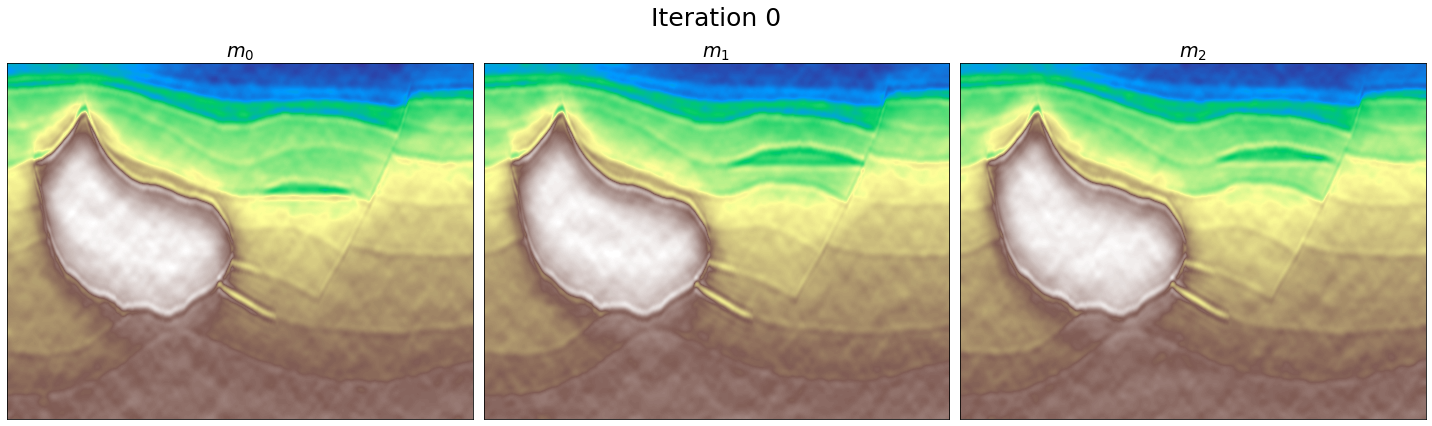

Solving for v


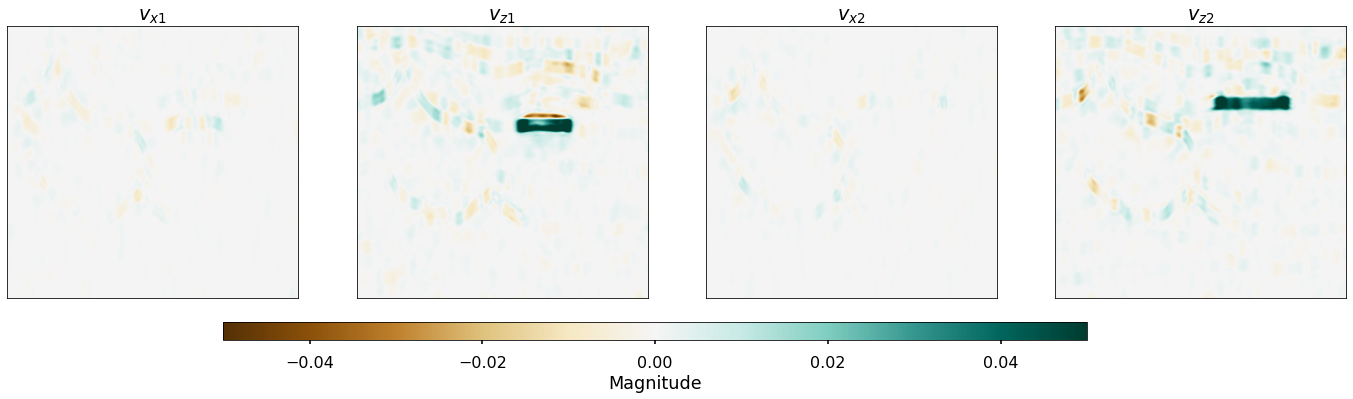

 20%|██        | 1/5 [00:47<03:08, 47.03s/it]

Iteration 1
Solving for m


Solving for v


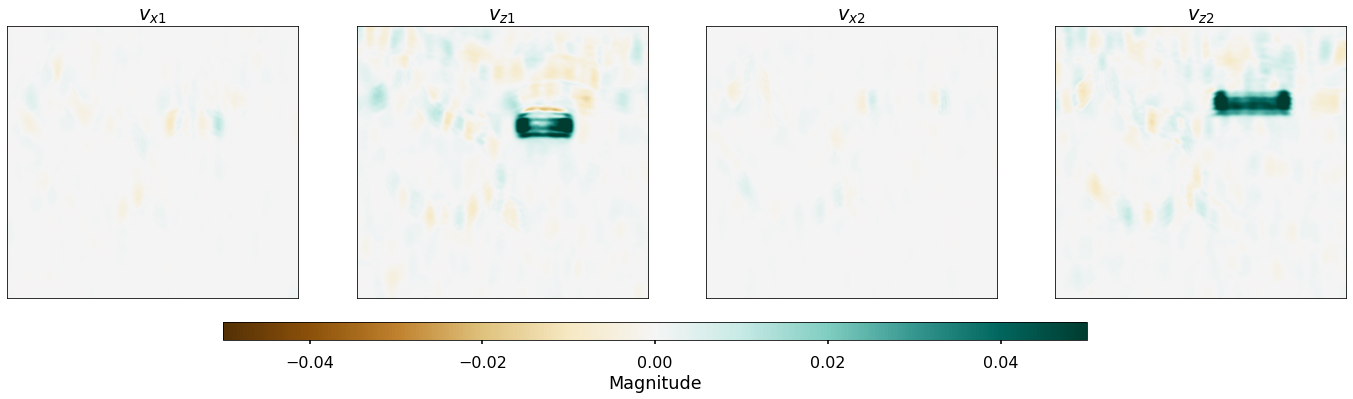

 40%|████      | 2/5 [02:00<03:07, 62.36s/it]

Iteration 2
Solving for m


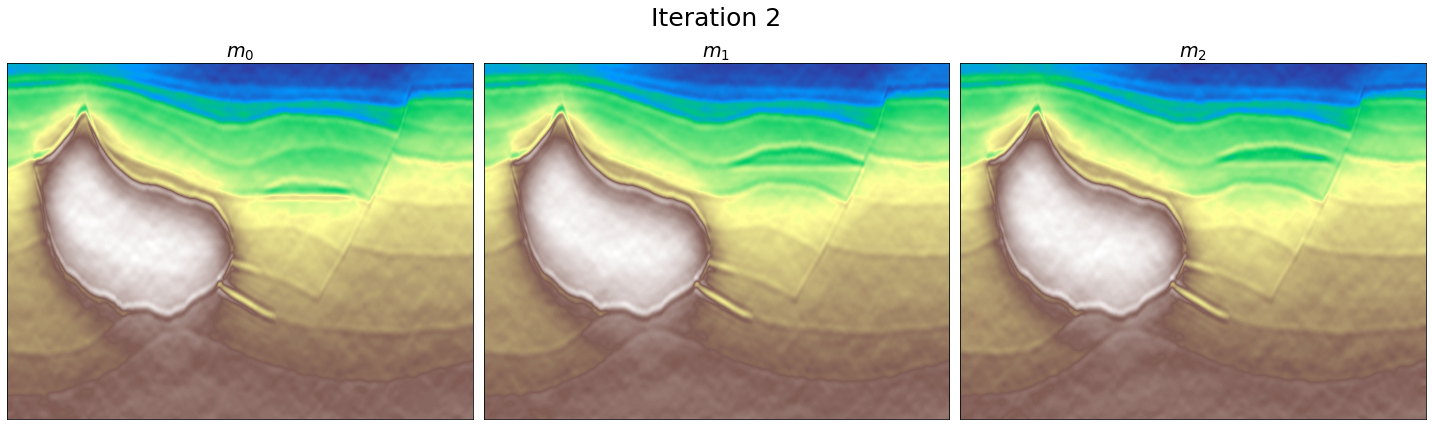

Solving for v


 60%|██████    | 3/5 [03:15<02:16, 68.10s/it]

Iteration 3
Solving for m


Solving for v


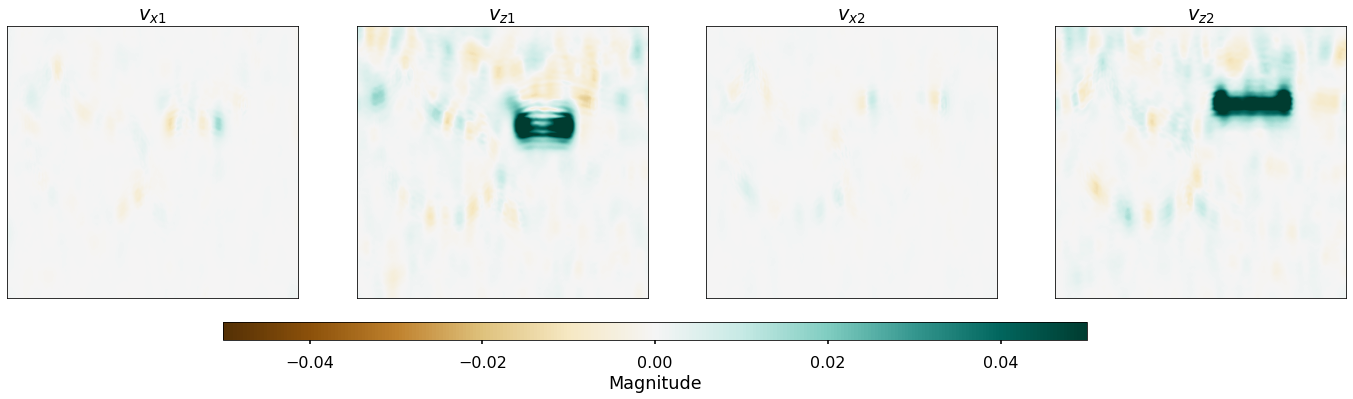

 80%|████████  | 4/5 [04:24<01:08, 68.55s/it]

Iteration 4
Solving for m


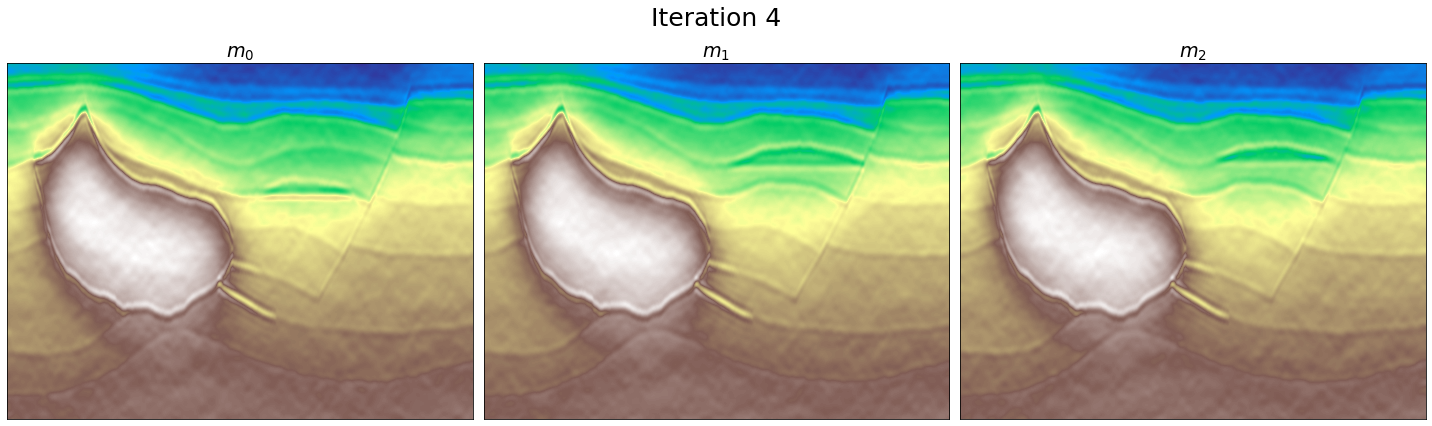

Solving for v


100%|██████████| 5/5 [05:37<00:00, 67.53s/it]


In [20]:
# Plotting parameters
cmap = cc.m_CET_C3
lim = 5e-3
display_progress = False
plot_angles = False

# Inversion parameters
iters = 5  # Number of iterations
v = np.zeros(nt0*nx*4)  # Starting point for v
pd_iter = 50  # PrimalDual iterations

sigma_v = 4  # Weight of the TV regularization of the velocity
sigma = 5  # Weight of the TV regularization of the model m
beta = 0.3  # Weight of the optical flow equation when solving for m

m_list = []
v_list = []

for i in tqdm(range(iters)):

    print(f'Iteration {i}')

    if i == 0:
        # Solve for m using primal dual with TV

        print('Solving for first m')

        l2_2 = L2(Op=G, b=dn, niter=20, warm=True)  # L2 Norm proximal operator to use for fitting the data (we apply it to delta_dn)
        Dzop = FirstDerivative(dims=(nt0, nx), axis=0, edge=True, dtype=G.dtype, kind='forward')  # Finite difference operator for TV along x
        Dxop = FirstDerivative(dims=(nt0, nx), axis=1, edge=True, dtype=G.dtype, kind='forward')  # Finite difference operator for TV along z
        Zop = Zero(nx * nt0, dtype='float64')  # Zero matrix for construction of the problem

        DOP_m = Block([[Dzop, Zop, Zop],
                     [Zop, Dzop, Zop],
                     [Zop, Zop, Dzop],
                     [Dxop, Zop, Zop],
                     [Zop, Dxop, Zop],
                     [Zop, Zop, Dxop]])

        l21 = L21(ndim=2, sigma=sigma)

        L = 24.
        tau = 1.  # Stepsize of the proximal operator f
        mu = 0.99 / (tau * L)  # Stepsize of the proximal operator g

        m = PrimalDual(l2_2, l21, DOP_m, m_start, tau=tau, mu=mu,
                         theta=1., niter=pd_iter, show=display_progress)

        plot_m(m)

    else:
        # Solve m with Mm

        print('Solving for m')

        _vxt0 = v[:nt0*nx]
        _vzt0 = v[nt0*nx:nt0*nx*2]
        _vxt1 = v[nt0*nx*2:nt0*nx*3]
        _vzt1 = v[nt0*nx*3:]

        Amt = Block([[Diagonal(_vxt0) * Dxop + Diagonal(_vzt0) * Dzop, Zop, Zop],
                    [Zop, Diagonal(_vxt1) * Dxop + Diagonal(_vzt1) * Dzop, Zop]])

        eyes = Block([[-Identity(nt0*nx), Identity(nt0*nx), Zop],
                      [Zop, -Identity(nt0*nx), Identity(nt0*nx)]])

        M_m = eyes + Amt
        G_aug = VStacklop([G, beta * M_m])
        dn_aug = np.hstack([dn, np.zeros(nt0*nx*2).ravel()])

        l2_2 = L2(Op=G_aug, b=dn_aug, niter=20, warm=True)  # L2 Norm proximal operator to use for fitting the data (we apply it to delta_dn)
        l21 = L21(ndim=2, sigma=sigma)

        L = 24.
        tau = 1.  # Stepsize of the proximal operator f
        mu = 0.99 / (tau * L)  # Stepsize of the proximal operator g

        m = PrimalDual(l2_2, l21, DOP_m, m, tau=tau, mu=mu,
                       theta=1., niter=pd_iter, show=display_progress)
        plot_m(m)

    m_list.append(m)

# Solve for v using optical flow equation

    print('Solving for v')
    _m0 = m[:nt0*nx]
    _m1 = m[nt0*nx:nt0*nx*2]
    _m2 = m[nt0*nx*2:]

    At0 = HStacklop( [Diagonal(Dxop * _m0 ), Diagonal(Dzop * _m0 )])
    At1 = HStacklop( [Diagonal(Dxop * _m1 ), Diagonal(Dzop * _m1 )])

    Mv = BlockDiag([At0, At1])
    dv = np.hstack([_m1 - _m0, _m2 - _m1])

    DOP_v = Block([[Dzop, Zop, Zop, Zop],
                 [Zop, Dzop, Zop, Zop],
                 [Zop, Zop, Dzop, Zop],
                 [Zop, Zop, Zop, Dzop],
                 [Dxop, Zop, Zop, Zop],
                 [Zop, Dxop, Zop, Zop],
                 [Zop, Zop, Dxop, Zop],
                 [Zop, Zop, Zop, Dxop]])

    l2_2_v = L2(Op=Mv, b=dv, niter=20, warm=True)
    l21_v = L21(ndim=2, sigma=sigma_v)

    L = 32.
    tau = 1.  # Stepsize of the proximal operator f
    mu = 0.99 / (tau * L)  # Stepsize of the proximal operator g

    v = PrimalDual(l2_2_v, l21_v, DOP_v, v, tau=tau, mu=mu,
                   theta=1., niter=pd_iter, show=display_progress)

    v_list.append(v)
    plot_vel(v, plot_angles, clim=1/20)

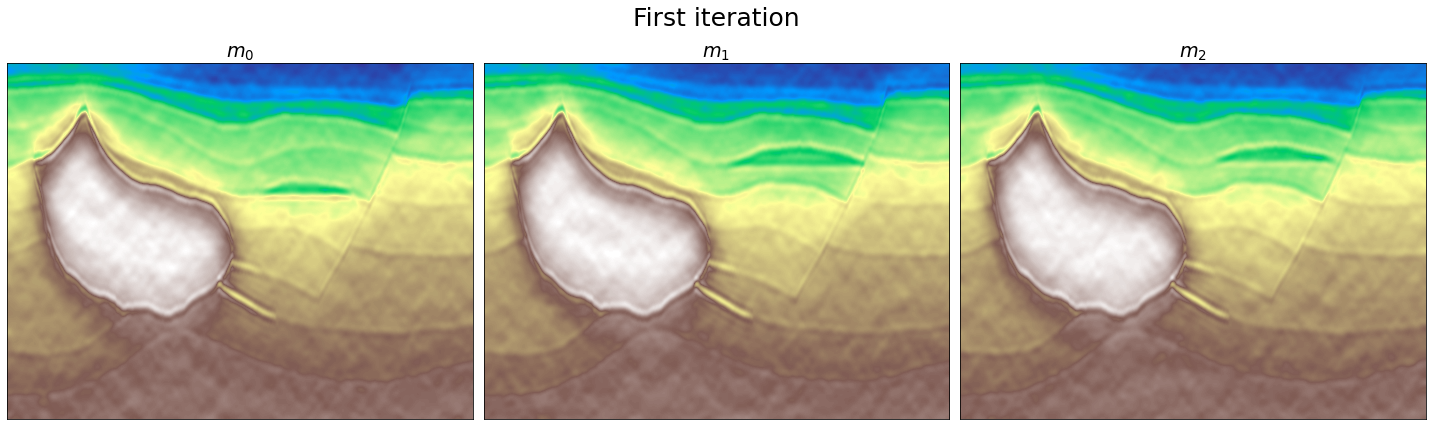

In [31]:
plot_m(m_list[0], 'First iteration')
plt.savefig('iter0models.png', dpi=150)

In [341]:
plot_vel(v_list[-1], False, clim=1e-1)